- given an initial investment and monthly investment
    - assume a particular particular asset it should track
    - although realistically the composition/allocation should change over time to e.g. bonds that have less volitility
        - would be nice to be able to include 2 assets and specify how the allocation should linearly change over time
    - for that particular asset
        - for each datapoint/day, calculate the percent increase in one month
        - determine some sort of bootstrap resampling or distribution model to simulate the percent increase in the next month
    - understand most likely range of possible ending values for retirement
-  model possible tax brackets when selling investment
    - sell when either A) changing allocation B) selling investment for retirement
        - either way, each purchase needs to track it's own duration & long/short term possible rates
- model possible inflation rates, convert annual to monthly
- consider desired living expenses (consider inflation and what I need in future $)

- NOTE: fidelity and vanguard are with Roth 401k so no taxes when i withdraw

---


- Vanguard Total Bond Market Index Fund (VBTLX)
    - How to include dividends?


---

https://www.reddit.com/r/personalfinance/comments/9l4rpk/what_do_you_do_with_your_401k_once_you_retire/


The 4% rule assumes 30 years of withdrawals with annual increases in the withdrawal amount to account for inflation. If you were going to follow that rule, at retirement you would set a withdrawal amount equal to 4% of your retirement funds balance. Every year you would increase that amount to account for inflation. If you follow this you have a very high probability of going at least 30 years without running out of money.

The "4% rule" actually says that if you withdraw 4% of your savings each year then you will probably not run out of money. There is some debate about that and you can go online to read the discussions, but 4% of a lot of money is much better than 4% of a little bit of money, so save early and save often.


---

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px

period = "100y"
symbol_vti = "VTI" # Vanguard Total Stock Market ETF
symbol_vbtlx = "VBTLX"


def create_title(title: str, subtitle: str = None) -> str:
    title = f"<b>{title}</b>"
    if subtitle:
        title += f"<br><sup>{subtitle}</sup>"
    return title

def annualized_return(initial: float, final: float, num_years) -> float:
    return (final / initial) ** (1 / num_years) - 1

def percent_increase(initial: float, final: float) -> float:
    return (final - initial) / initial

def format_percent(x: float, round_by=2) -> str:
    return f"{round(x * 100, round_by)}%"


# wont give exact match; going out 40 years will be off by a few weeks, but it doesn't matter
# for our purposes
num_trading_days_per_year = 252
num_trading_days_per_month = round(num_trading_days_per_year / 12)
num_trading_days_per_month

21

In [10]:
symbol = symbol_vbtlx
daily_prices = yf.Ticker(symbol).history(period=period)
daily_prices.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2001-11-12 00:00:00-05:00,5.267743,5.267743,5.267743,5.267743,0,0.0,0.0,0.0
2001-11-13 00:00:00-05:00,5.257652,5.257652,5.257652,5.257652,0,0.0,0.0,0.0
2001-11-14 00:00:00-05:00,5.232419,5.232419,5.232419,5.232419,0,0.0,0.0,0.0
2001-11-15 00:00:00-05:00,5.187007,5.187007,5.187007,5.187007,0,0.0,0.0,0.0
2001-11-16 00:00:00-05:00,5.156735,5.156735,5.156735,5.156735,0,0.0,0.0,0.0


In [141]:
def get_percent_increases(df: pd.DataFrame, num_months: int) -> pd.DataFrame:
    """
    Given a DataFrame of daily close prices with a datetime index and a corresponding `Close`
    column, this function will return a DataFrame with three added columns. One column, `Target`
    will contain the value of the stock/etf/etc *approximately* `num_months` from the coresponding 
    date for each row of the DataFrame. Note that the daily prices only contain rows for weekdays
    excluding holidays so it will be close, but not exactly `num_months` from the date. The second
    column added will be a `Percent Increase` column, and the third will be a `Annualized
    Return` column
    
    Args:
        df: DataFrame containing daily close prices
        num_months: the number of months in the future to grab the close price.
    """
    num_rows_horizon = num_months * num_trading_days_per_month

    df = df[['Close']].copy()
    df['Target Date'] = pd.DataFrame(pd.to_datetime(df.index)).shift(num_rows_horizon * -1)['Date'].values
    df['Target'] = df['Close'].shift(num_rows_horizon * -1)
    df['Percent Increase'] = percent_increase(initial=df['Close'], final=df['Target'])
    return df

In [142]:
monthly_increases = get_percent_increases(daily_prices, num_months=1)
monthly_increases = monthly_increases[~monthly_increases['Percent Increase'].isna()]
assert not monthly_increases.isna().any().any()
monthly_increases.head(20)

,Close,Target Date,Target,Percent Increase
Date,,,,
2001-11-12 00:00:00-05:00,5.267743,2001-12-12 05:00:00,5.126461,-0.026820
2001-11-13 00:00:00-05:00,5.257652,2001-12-13 05:00:00,5.106279,-0.028791
2001-11-14 00:00:00-05:00,5.232419,2001-12-14 05:00:00,5.086098,-0.027964
2001-11-15 00:00:00-05:00,5.187007,2001-12-17 05:00:00,5.086098,-0.019454
2001-11-16 00:00:00-05:00,5.156735,2001-12-18 05:00:00,5.091137,-0.012721
2001-11-19 00:00:00-05:00,5.181964,2001-12-19 05:00:00,5.111325,-0.013632
2001-11-20 00:00:00-05:00,5.166828,2001-12-20 05:00:00,5.111325,-0.010742
2001-11-21 00:00:00-05:00,5.146642,2001-12-21 05:00:00,5.106279,-0.007843
2001-11-23 00:00:00-05:00,5.136555,2001-12-24 05:00:00,5.096186,-0.007859


In [27]:
monthly_increases.tail(10)

,Close,Target Date,Target,Percent Increase
Date,,,,
2022-11-16 00:00:00-05:00,9.487977,2022-12-16 05:00:00,9.71,0.023400
2022-11-17 00:00:00-05:00,9.438093,2022-12-19 05:00:00,9.65,0.022452
2022-11-18 00:00:00-05:00,9.428116,2022-12-20 05:00:00,9.58,0.016110
2022-11-21 00:00:00-05:00,9.428116,2022-12-21 05:00:00,9.60,0.018231
2022-11-22 00:00:00-05:00,9.468023,2022-12-22 05:00:00,9.59,0.012883
2022-11-23 00:00:00-05:00,9.517907,2022-12-23 05:00:00,9.56,0.004423
2022-11-25 00:00:00-05:00,9.517907,2022-12-27 05:00:00,9.50,-0.001881
2022-11-28 00:00:00-05:00,9.517907,2022-12-28 05:00:00,9.48,-0.003983
2022-11-29 00:00:00-05:00,9.478001,2022-12-29 05:00:00,9.51,0.003376


In [147]:
monthly_increases.index

DatetimeIndex(['2001-11-12 00:00:00-05:00', '2001-11-13 00:00:00-05:00',
               '2001-11-14 00:00:00-05:00', '2001-11-15 00:00:00-05:00',
               '2001-11-16 00:00:00-05:00', '2001-11-19 00:00:00-05:00',
               '2001-11-20 00:00:00-05:00', '2001-11-21 00:00:00-05:00',
               '2001-11-23 00:00:00-05:00', '2001-11-26 00:00:00-05:00',
               ...
               '2022-11-16 00:00:00-05:00', '2022-11-17 00:00:00-05:00',
               '2022-11-18 00:00:00-05:00', '2022-11-21 00:00:00-05:00',
               '2022-11-22 00:00:00-05:00', '2022-11-23 00:00:00-05:00',
               '2022-11-25 00:00:00-05:00', '2022-11-28 00:00:00-05:00',
               '2022-11-29 00:00:00-05:00', '2022-11-30 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=5300, freq=None)

In [393]:
px.line(
    monthly_increases,
    x=monthly_increases.index,
    y=monthly_increases['Close'],
    title="Close",
    labels={'y': 'Close'}
)

In [185]:
import plotly.express as px
log_y = False
# Plot the log of the values with a loess curve
lowess_graph = px.scatter(
    monthly_increases,
    x=monthly_increases.index,
    y=np.log(monthly_increases['Close']),
    log_y=log_y,
    trendline='lowess',
    trendline_options=dict(frac=0.18),
    trendline_color_override = 'red',
)
ols_graph = px.scatter(
    monthly_increases,
    x=monthly_increases.index,
    y=np.log(monthly_increases['Close']),
    log_y=log_y,
    trendline='ols',
    #trendline_options=dict(frac=0.18),
    trendline_color_override = 'red',
)
#lowess_graph.data[0].update(visible=False)
#lowess_graph.update_traces(line_color='red', line_width=5)
# Show the plot
fig = px.line(
    monthly_increases,
    x=monthly_increases.index,
    y=np.log(monthly_increases['Close']),
    log_y=log_y,
    title="Log Close",
    labels={'y': 'Log Close'}
)
fig.add_trace(lowess_graph.data[1])
fig.add_trace(ols_graph.data[1])
fig.show()

In [186]:
# create a scatter plot so that we can get extract the regression line
# (can only do regression line with scatter)
subset = daily_prices#.loc['1980-01-01':'2020-01-01']
fig_scatter = px.scatter(
    subset,
    x=subset.index,
    y=np.log(subset['Close']),
    trendline="ols",
)
fig = px.line(
    daily_prices,
    x=daily_prices.index,
    y=np.log(daily_prices['Close']),
    title=create_title(
        title=f"Log of Daily Close Prices of `{symbol}`",
        subtitle="On a logarithmic scale, each increment represents a multiplicative increase " \
        "rather than an additive increase."
    ),
    labels={'y': "Log Close Price"},
)
fig.add_trace(fig_scatter.data[1])
fig.show()

0.002537175540235129
0.003213966308664275


<AxesSubplot: >

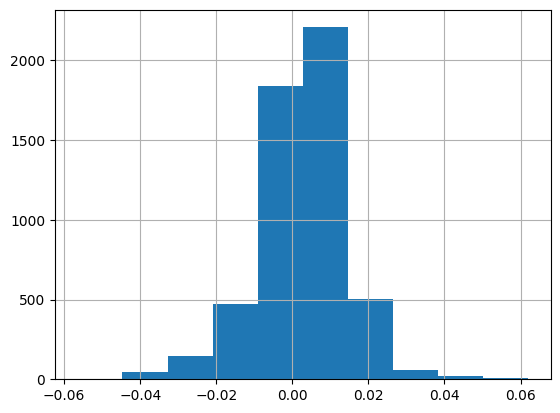

In [28]:
print(monthly_increases['Percent Increase'].mean())
print(monthly_increases['Percent Increase'].median())
monthly_increases['Percent Increase'].hist()

0.0022711766700841203
0.002983215619198225


<AxesSubplot: >

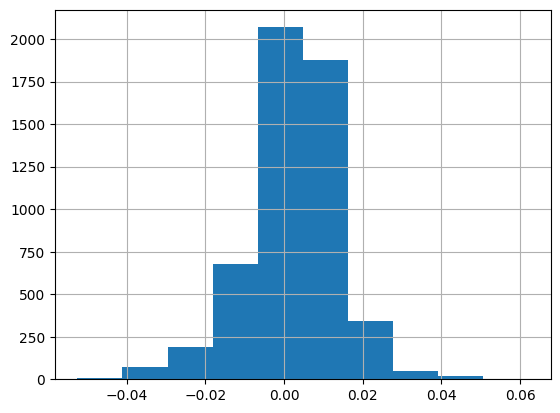

In [140]:
temp_sample = monthly_increases['Percent Increase'].sample(n=len(monthly_increases), replace=True)
print(temp_sample.mean())
print(temp_sample.median())
temp_sample.hist()

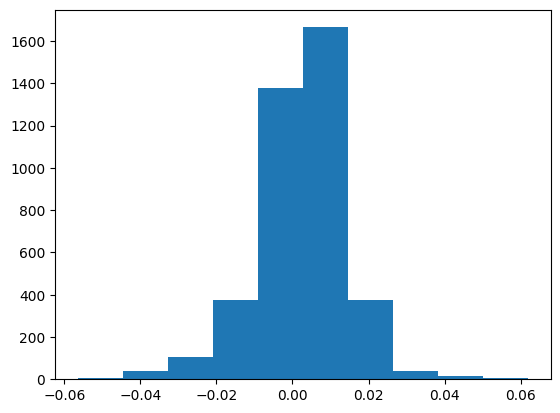

In [311]:
def sample():
    #return monthly_increases['Percent Increase'].sample(1).iloc[0]
    return monthly_increases['Percent Increase'].sample(n=len(monthly_increases), replace=True).sample(1).iloc[0]

def simulate(num_sims):
    arr = np.empty(num_sims)
    for i in range(num_sims):
        arr[i] = sample()
    return arr


sims = simulate(num_sims=4000)

import numpy as np
import matplotlib.pyplot as plt

hist, edges = np.histogram(sims)

# Plot the histogram
plt.hist(sims, bins=edges)
plt.show()

In [312]:
quantiles = np.quantile(sims, [0, 0.25, 0.5, 0.75, 1])
print(quantiles)

[-0.05651728 -0.00380011  0.00325188  0.00953603  0.06204697]


In [320]:
daily_prices.index.values[0]

numpy.datetime64('2001-11-12T05:00:00.000000000')

In [321]:
print(daily_prices.index.values[0])
print(daily_prices.index.values[-1])
print(daily_prices.iloc[-1]['Close'])

2001-11-12T05:00:00.000000000
2022-12-30T05:00:00.000000000
9.479999542236328


In [335]:
num_days = (pd.Timestamp(daily_prices.index.values[-1]) - pd.Timestamp(daily_prices.index.values[0])).days
num_days / 365

21.145205479452056

In [339]:
num_months = round(num_days / 365 * 12)
num_months

254

In [340]:
starting_value = daily_prices.iloc[0]['Close']
starting_value

5.267743110656738

In [ ]:
# num_simulations = 4000
# arr = np.zeros(shape=(num_months, num_simulations))

# sims = simulate(num_sims=num_simulations)
# for i in range(num_months):
#     for j in range(num_simulations):
#         arr[i][i] = sample()
# arr

In [361]:
def samples(n):
    return monthly_increases['Percent Increase'].sample(n=n, replace=True).values

temp = samples(20)
temp

array([-0.02748515, -0.00195106,  0.00901707,  0.01664126,  0.01019702,
        0.00382586, -0.01191717,  0.00710304, -0.00021516, -0.00779741,
        0.00722342,  0.01067685, -0.00807844,  0.00788078, -0.01197004,
        0.01128946, -0.00363236, -0.01413236, -0.01355247,  0.00096492])

In [365]:
np.reshape(temp, (-1, ))

array([[-0.02748515, -0.00195106,  0.00901707,  0.01664126],
       [ 0.01019702,  0.00382586, -0.01191717,  0.00710304],
       [-0.00021516, -0.00779741,  0.00722342,  0.01067685],
       [-0.00807844,  0.00788078, -0.01197004,  0.01128946],
       [-0.00363236, -0.01413236, -0.01355247,  0.00096492]])

In [378]:
# each row represents a month, each column represents a potential outcome
num_simulations = 4000
simulated_percent_change = samples(n=num_months * num_simulations)
simulated_percent_change = np.reshape(simulated_percent_change, (-1, num_simulations))
#(simulated_percent_change == 0).sum()
print(simulated_percent_change.shape)
simulated_percent_change

(254, 4000)


array([[ 0.00310965,  0.00036293, -0.00165196, ...,  0.00793582,
         0.00847634,  0.01193288],
       [ 0.00387122,  0.00551209,  0.02780724, ..., -0.00189756,
        -0.002323  ,  0.0116184 ],
       [-0.0096896 ,  0.0008317 , -0.03433461, ...,  0.00285177,
        -0.01191141, -0.00054243],
       ...,
       [ 0.00933949, -0.00793726,  0.00306981, ..., -0.00582569,
         0.01437247, -0.00248127],
       [ 0.00925768, -0.00446369,  0.00542184, ...,  0.00623442,
         0.01185243, -0.00809181],
       [ 0.03257421,  0.02533479,  0.00672892, ...,  0.00474953,
         0.0008898 ,  0.00586788]])

In [382]:
starting_value

5.267743110656738

In [381]:
starting_value + (starting_value * simulated_percent_change[0, :])

array([5.28412394, 5.26965491, 5.25904099, ..., 5.30954697, 5.31239428,
       5.33060247])

In [390]:
arr[1] + (arr[1] * simulated_percent_change[0, :])

array([1.00310965, 1.00036293, 0.99834804, ..., 1.00793582, 1.00847634,
       1.01193288])

In [394]:
simulations = np.zeros(shape=(num_months+1, num_simulations))
simulations[0, :] = starting_value

sims = simulate(num_sims=num_simulations)
for i in range(1, num_months + 1):
    simulations[i] = simulations[i-1] + (simulations[i-1] * simulated_percent_change[i-1, :])
    
simulations

array([[ 5.26774311,  5.26774311,  5.26774311, ...,  5.26774311,
         5.26774311,  5.26774311],
       [ 5.28412394,  5.26965491,  5.25904099, ...,  5.30954697,
         5.31239428,  5.33060247],
       [ 5.30457995,  5.29870171,  5.40528043, ...,  5.2994718 ,
         5.30005358,  5.39253556],
       ...,
       [ 9.67073629, 13.60827706,  7.35559798, ...,  7.82805303,
        10.8239865 , 10.32459643],
       [ 9.76026492, 13.54753394,  7.39547884, ...,  7.87685638,
        10.95227703, 10.24105178],
       [10.07819787, 13.89075781,  7.44524242, ...,  7.91426771,
        10.96202239, 10.301145  ]])

In [395]:
simulations

array([[ 5.26774311,  5.26774311,  5.26774311, ...,  5.26774311,
         5.26774311,  5.26774311],
       [ 5.28412394,  5.26965491,  5.25904099, ...,  5.30954697,
         5.31239428,  5.33060247],
       [ 5.30457995,  5.29870171,  5.40528043, ...,  5.2994718 ,
         5.30005358,  5.39253556],
       ...,
       [ 9.67073629, 13.60827706,  7.35559798, ...,  7.82805303,
        10.8239865 , 10.32459643],
       [ 9.76026492, 13.54753394,  7.39547884, ...,  7.87685638,
        10.95227703, 10.24105178],
       [10.07819787, 13.89075781,  7.44524242, ...,  7.91426771,
        10.96202239, 10.301145  ]])

In [399]:
simulations[index, :]

5.267743110656738

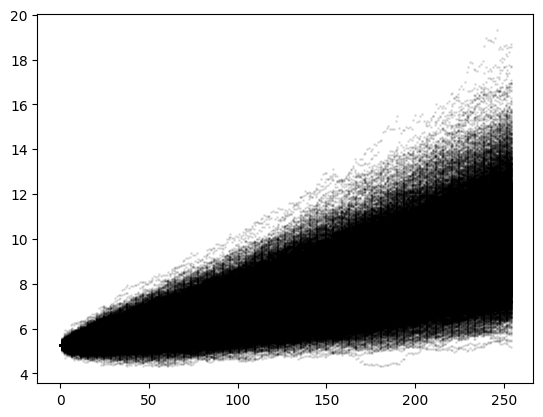

In [406]:
for index in range(len(simulations)):
    plt.scatter(np.repeat(index, num_simulations), simulations[index, :], alpha=0.1, s=1, color='black')
plt.show()

---

# Appendix

In [2]:
symbol = symbol_vbtlx
daily_prices = yf.Ticker(symbol).history(period=period)
daily_prices.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2001-11-12 00:00:00-05:00,5.267742,5.267742,5.267742,5.267742,0,0.0,0.0,0.0
2001-11-13 00:00:00-05:00,5.257650,5.257650,5.257650,5.257650,0,0.0,0.0,0.0
2001-11-14 00:00:00-05:00,5.232420,5.232420,5.232420,5.232420,0,0.0,0.0,0.0
2001-11-15 00:00:00-05:00,5.187007,5.187007,5.187007,5.187007,0,0.0,0.0,0.0
2001-11-16 00:00:00-05:00,5.156734,5.156734,5.156734,5.156734,0,0.0,0.0,0.0


In [3]:
daily_prices['Dividends'].sum()

6.849

In [4]:
daily_prices['Capital Gains'].sum()

0.316

In [11]:
daily_prices['Stock Splits'].sum()

0.0

In [5]:
fig = px.line(
    daily_prices,
    x=daily_prices.index,
    y='Close',
    title=create_title(f"Daily Close Price of `{symbol}`"),
    labels={'Close': "Close Price"},
)
fig.show()

In [6]:
def get_percent_increases(df: pd.DataFrame, num_years: int) -> pd.DataFrame:
    """
    Given a DataFrame of daily close prices with a datetime index and a corresponding `Close`
    column, this function will return a DataFrame with three added columns. One column, `Target`
    will contain the value of the stock/etf/etc *approximately* `num_years` from the coresponding 
    date for each row of the DataFrame. Note that the daily prices only contain rows for weekdays
    excluding holidays so it will be close, but not exactly `num_years` from the date. The second
    column added will be a `Percent Increase` column, and the third will be a `Annualized
    Return` column
    
    Args:
        df: DataFrame containing daily close prices
        num_years: the number of years in the future to grab the close price.
    """
    # X years in this data is not X*10, because it only shows weekdays excluding holidays
    # so we are just getting an approximate number of rows to skip that represents a X-year span 
    num_rows_horizon = num_years * num_trading_days_per_year

    df = df[['Close']].copy()
    df['Target Date'] = pd.DataFrame(pd.to_datetime(df.index)).shift(num_rows_horizon * -1)['Date'].values
    df['Target'] = df['Close'].shift(num_rows_horizon * -1)
    df['Percent Increase'] = percent_increase(initial=df['Close'], final=df['Target'])
    df['Annualized Return'] = annualized_return(
        initial=df['Close'],
        final=df['Target'],
        num_years=num_years
    )
    return df

# get_percent_increases(daily_prices, num_years=10)

In [7]:
prices_after_10_years = get_percent_increases(df=daily_prices, num_years=10)
prices_after_10_years

,Close,Target Date,Target,Percent Increase,Annualized Return
Date,,,,,
2001-11-12 00:00:00-05:00,5.267742,2011-11-14 05:00:00,8.176572,0.552197,0.044948
2001-11-13 00:00:00-05:00,5.257650,2011-11-15 05:00:00,8.169147,0.553764,0.045053
2001-11-14 00:00:00-05:00,5.232420,2011-11-16 05:00:00,8.183998,0.564094,0.045746
2001-11-15 00:00:00-05:00,5.187007,2011-11-17 05:00:00,8.183998,0.577788,0.046658
2001-11-16 00:00:00-05:00,5.156734,2011-11-18 05:00:00,8.169147,0.584170,0.047081
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,9.560000,NaT,NaN,NaN,NaN
2022-12-27 00:00:00-05:00,9.500000,NaT,NaN,NaN,NaN
2022-12-28 00:00:00-05:00,9.480000,NaT,NaN,NaN,NaN


In [9]:
fig = px.box(
    data_frame=prices_after_10_years,
    y='Annualized Return',
    title=create_title(
        title=f"Annualized Rate of Return over 10 Years (`{symbol}`)",
        subtitle="Each point in the data represents investing at a particular point in time.<br>" \
            "This graph shows the annualized rate of investing a single sum at a specific " \
            "point and then waiting 10 years."
    ),
)
fig.layout.yaxis.tickformat = ',.0%'
fig.show()